# Jupyter notebook for doing some basic data analysis and running a logisitic regression to predict kidney faliures in diabetics

# Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes). 

"medcalc.org - > http://medcalc.org/manual/logistic_regression.php"


# In our sample dataset we have 200 patients with predictors like HBA1CCategory , GlucoseCategory , HasDiabetesRetinopathy , Gender , and Race. We are predicting a kidney faiure in the control group.

# This notebook will guide you with the steps to peform a very basic logisitic regression on the data we collected from source database and the AWS IOT button. 

# Data analysis involves connecting to the database , performing basic descriptive analytics , feature exploration, modelling, and evaluating coffiecients and confusion matrix. 


# Loading Packages - PYMYSQL , SEABORN , SCIKIT , MATLIBPLOT , NUMPY , PANDAS , SYS , DATETIME , RANDOM

In [3]:
#Import statements , laoding basic packages for data analysis
import sys
import logging

import random
import datetime
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
plt.style.use('ggplot')


import pandas as pd
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)





# Next Few sections helps style the notebook output

In [4]:
#Styling the Pandas Data Frames

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML
from pandas.io.formats.style import Styler

from IPython.display import display, HTML


In [5]:
%mkdir templates


In [6]:
%%file templates/myhtml.tpl
{% extends "html.tpl" %}
{% block table %}
<h1>{{ table_title|default("My Table") }}</h1>
{{ super() }}
{% endblock table %}

Writing templates/myhtml.tpl


In [7]:
class MyStyler(Styler):
    env = Environment(
        loader=ChoiceLoader([
            FileSystemLoader("templates"),  # contains ours
            Styler.loader,  # the default
        ])
    )
    template = env.get_template("myhtml.tpl")

# Data Analysis  - Connecting to the RDS database , and runnign some basic descriptive analysis.
# NOTE: Please replace the rds_host parameter with your RDS host. You can find the information in the outputs tab of the CloudFormation stack. 

In [8]:
#rds connection paramters. PLEASE REFER TO CLOUD FORMATION TEMPLATE OUTPUTS FOR YOUR RDS HOST AND OTHER CONNECTION DETAILS"
rds_host  =  "Your_RDS_host.com"
name = "master"
password = "4we4df234"
db_name = "diabetes"

# Connecting to the RDS database using PYMYSQL and running some basic queries on the LABS and DiabetesStudy.

# We have about 200 patients in the diabetes.patients table.
# LABS TABLE CONTAINS 3 TYPES OF LAB TYPES.
# Glucose test, HBA1C , GFR for each patient.

# DiabetesStudy table is a transformed output created by AWS GLUE. As per the transformatio logic , patients are distributed in various risk categories. Fraction of patients already have a Kidney disease.


# GlucoseCategory ( in DiabetesStudy table ) 


# WHEN AVG(LabValue) <110 THEN  'OK' 
# WHEN AVG(LabValue) >110 and AVG(LabValue) < 140 THEN 'HIGH' 
# WHEN AVG(LabValue) >140 and AVG(LabValue) < 180 THEN 'VERY HIGH' 
# WHEN AVG(LabValue) > 180  THEN 'EXTREMELY HIGH' 


# HBA1CCategory ( in DiabetesStudy table )

# WHEN AVG(LabValue) <7.0 THEN  'OK' 
# WHEN AVG(LabValue) > 7.0 and AVG(LabValue) < 8.5 THEN 'HIGH' 
# WHEN AVG(LabValue) > 8.5 THEN 'VERY HIGH' 

# Case groups are the patients with Kidney disease and and control groups are the ones without Kidney disease. 



In [9]:
# Open database connection using pymysql  and setting index
conn = pymysql.connect(rds_host, user=name, passwd=password, db=db_name, connect_timeout=90)
dfDiabetesStudy = pd.read_sql_query("select * from diabetes.DiabetesStudy", conn, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)
dfLabs = pd.read_sql_query("select * from diabetes.Labs", conn, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)
dfLabs.set_index('LabID')
print(dfDiabetesStudy.count())
print(dfLabs.count())


,LabType,PatientID,LabValue,LabDatetime
LabID,,,,
111,HBA1C,1,5.0,1/1/2016 12:00:00 AM
112,HBA1C,1,5.0,2/1/2016 12:00:00 AM
113,HBA1C,1,5.0,3/1/2016 12:00:00 AM
114,HBA1C,1,6.0,4/1/2016 12:00:00 AM
115,HBA1C,1,6.0,5/1/2016 12:00:00 AM
116,HBA1C,1,5.0,6/1/2016 12:00:00 AM
117,HBA1C,1,6.0,7/1/2016 12:00:00 AM
118,HBA1C,1,6.0,8/1/2016 12:00:00 AM
119,HBA1C,1,5.0,9/1/2016 12:00:00 AM


PatientID                 200
PatientGender             200
PatientRace               200
HasKidneyDisease          200
HasDiabeticRetinopathy    200
HasHighHBA1C              200
HBA1CCategory             200
GlucoseCategory           200
dtype: int64
LabID          44612
LabType        44612
PatientID      44612
LabValue       44612
LabDatetime    44612
dtype: int64


# Simple formatting of a pandas dataframe output


In [10]:
HTML(dfDiabetesStudy.to_html())

,PatientID,PatientGender,PatientRace,HasKidneyDisease,HasDiabeticRetinopathy,HasHighHBA1C,HBA1CCategory,GlucoseCategory
0,78,F,American Indian or Alaska Native,0,0,0,ok,ok
1,53,F,Asian Indian,0,0,0,ok,ok
2,85,M,Asian Indian,0,0,0,ok,ok
3,148,M,Asian Indian,0,0,1,high,very high
4,137,M,Asian,0,0,1,high,very high
5,101,M,Filipino,0,0,1,high,very high
6,81,M,American Indian or Alaska Native,0,0,0,ok,ok
7,28,F,Asian Indian,1,1,1,very high,extremely high
8,183,M,Filipino,1,1,1,high,extremely high
9,34,F,Black or African American,1,1,1,high,very high


# Dataframe information.

In [11]:
dfDiabetesStudy.info()
dfLabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
PatientID                 200 non-null int64
PatientGender             200 non-null object
PatientRace               200 non-null object
HasKidneyDisease          200 non-null int64
HasDiabeticRetinopathy    200 non-null int64
HasHighHBA1C              200 non-null int64
HBA1CCategory             200 non-null object
GlucoseCategory           200 non-null object
dtypes: int64(4), object(4)
memory usage: 12.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44612 entries, 0 to 44611
Data columns (total 5 columns):
LabID          44612 non-null int64
LabType        44612 non-null object
PatientID      44612 non-null int64
LabValue       44612 non-null float64
LabDatetime    44612 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 1.7+ MB


# Basic descriptive analysis of the data using matlib plot functions
#

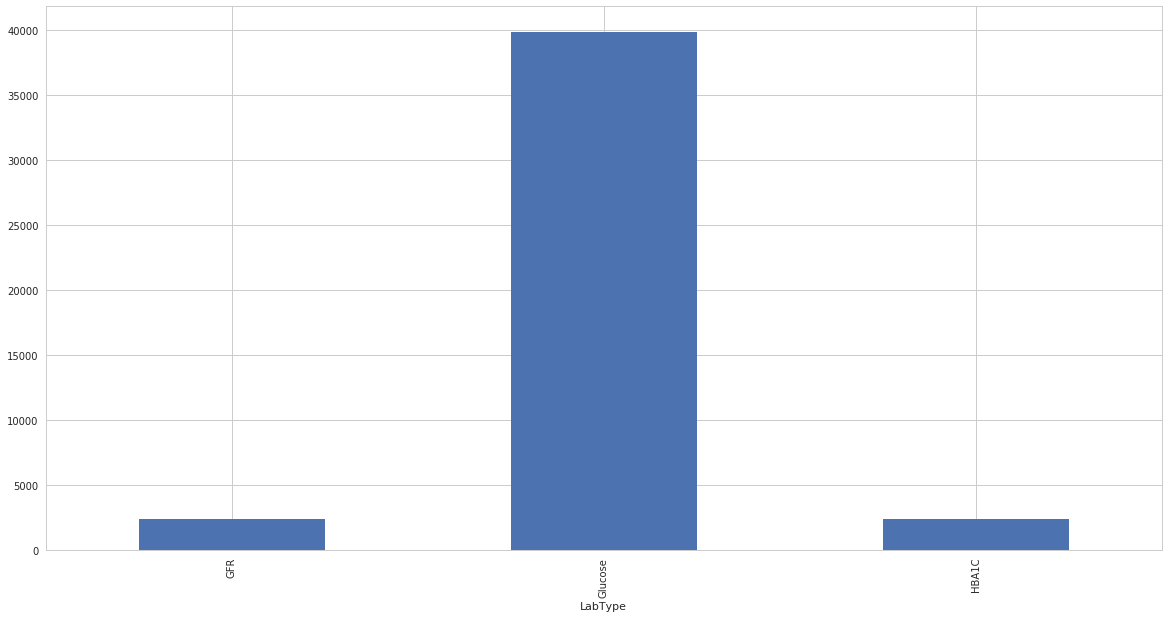

In [12]:
grph = dfLabs.groupby('LabType')['LabValue'].count().plot.bar(grid=True,figsize=(20,10))
plt.show()


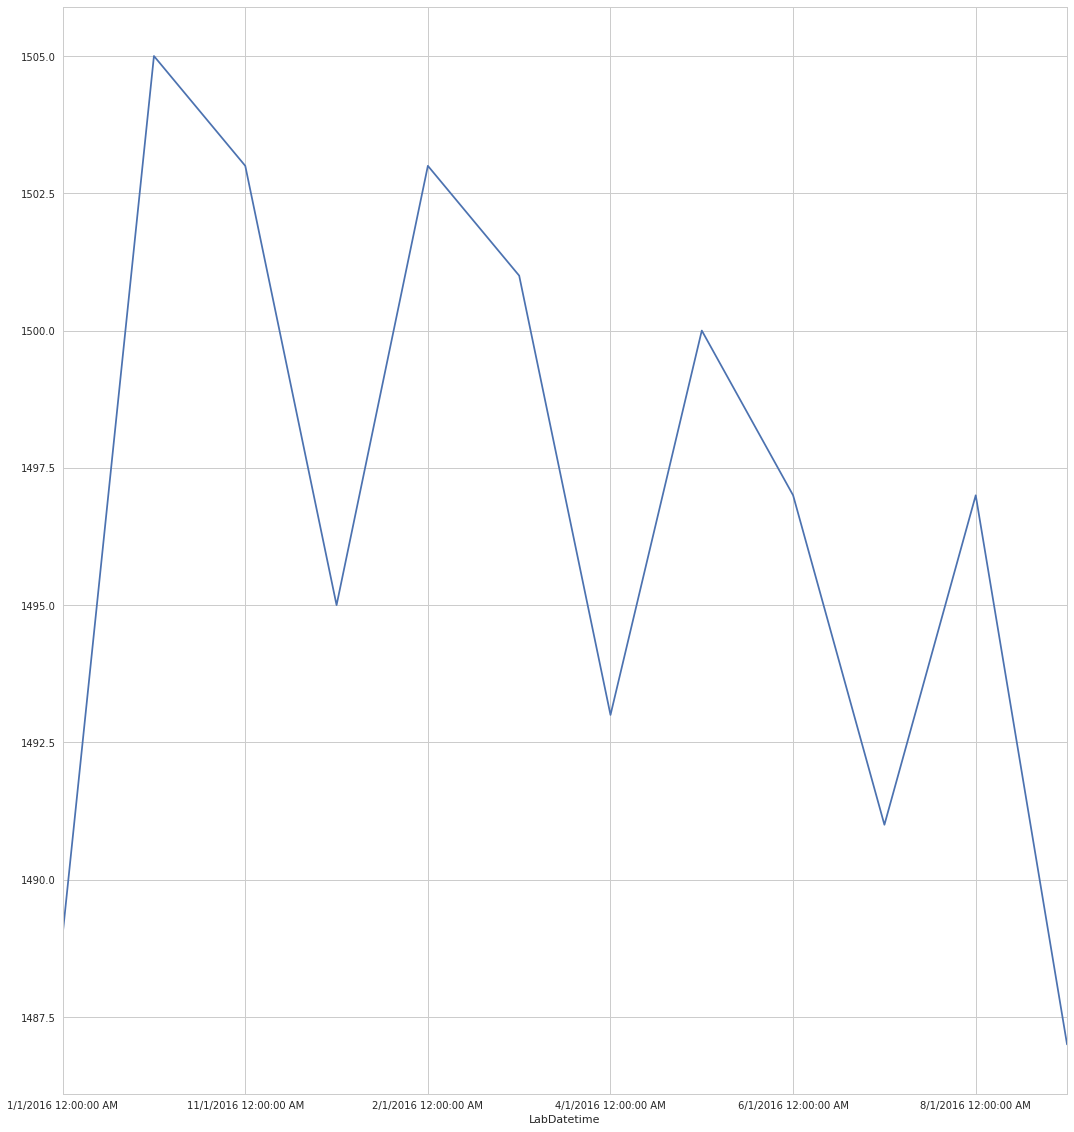

In [13]:
grph = dfLabs[dfLabs['LabType']=='HBA1C'].groupby('LabDatetime')['LabValue'].sum().plot(figsize=(18,20))

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca78bc5ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fca78b49be0>]], dtype=object)

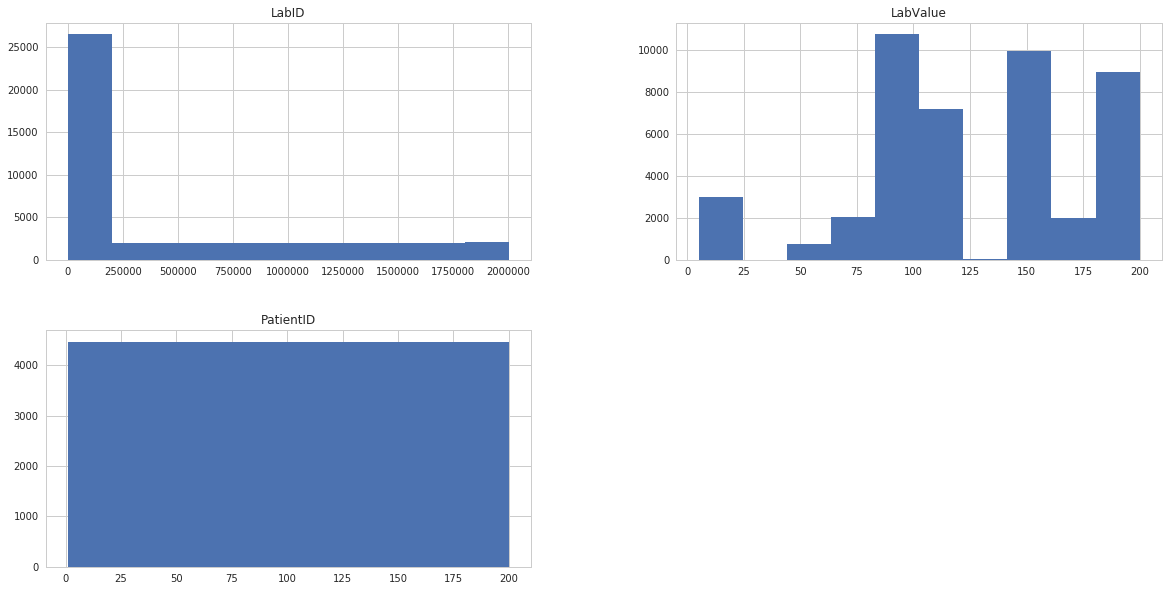

In [14]:
dfLabs.hist(figsize=(20,10))
plt.show()

In [15]:
dfDiabetesStudy.isnull().sum()

PatientID                 0
PatientGender             0
PatientRace               0
HasKidneyDisease          0
HasDiabeticRetinopathy    0
HasHighHBA1C              0
HBA1CCategory             0
GlucoseCategory           0
dtype: int64

# Basic descriptive analytics using seaborn. CountPlots and BarPlots with HUE/Series.

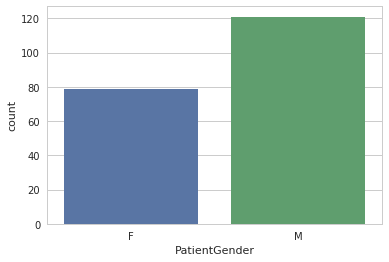

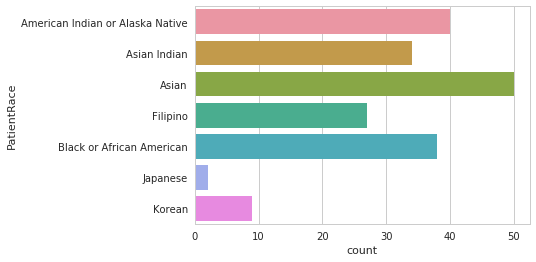

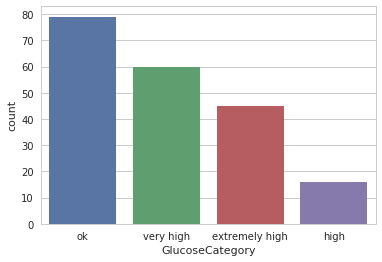

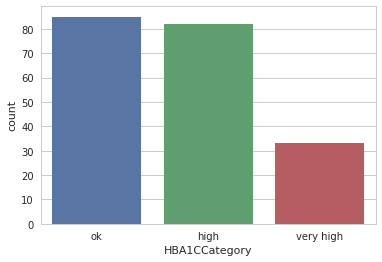

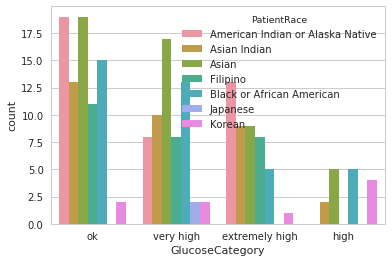

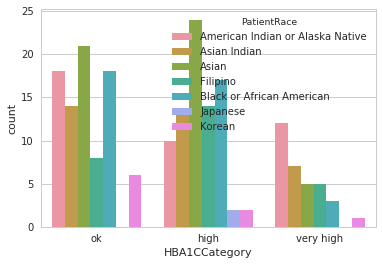

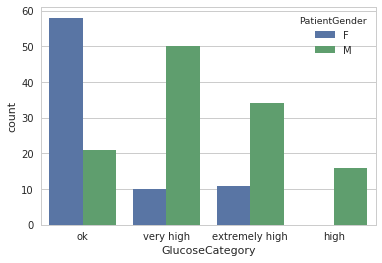

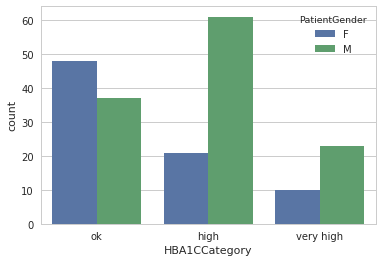

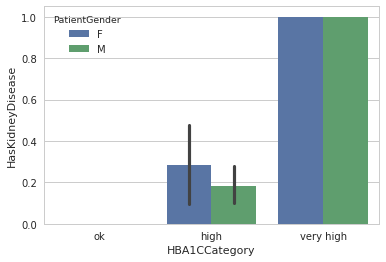

In [16]:
#grph = dfDiabetesStudy.groupby('PatientGender')['PatientID'].count().plot.bar(grid=True,figsize=(20,10))

sns.countplot(x="PatientGender", data=dfDiabetesStudy)
plt.show()

sns.countplot(y="PatientRace", data=dfDiabetesStudy)
plt.show()


sns.countplot(x="GlucoseCategory", data=dfDiabetesStudy)
plt.show()

sns.countplot(x="HBA1CCategory", data=dfDiabetesStudy)
plt.show()


sns.countplot(x="GlucoseCategory", hue="PatientRace", data=dfDiabetesStudy )
plt.show()

sns.countplot(x="HBA1CCategory",hue="PatientRace", data=dfDiabetesStudy)
plt.show()

sns.countplot(x="GlucoseCategory", hue="PatientGender", data=dfDiabetesStudy )
plt.show()

sns.countplot(x="HBA1CCategory",hue="PatientGender", data=dfDiabetesStudy)
plt.show()


sns.barplot(x="HBA1CCategory",y="HasKidneyDisease",hue="PatientGender", data=dfDiabetesStudy)
plt.show()


In [17]:
dfDiabetesStudy.groupby('HasKidneyDisease').mean()
dfDiabetesStudy.groupby('HasHighHBA1C').mean()
dfDiabetesStudy.groupby('HasDiabeticRetinopathy').mean()



,PatientID,HasDiabeticRetinopathy,HasHighHBA1C
HasKidneyDisease,,,
0,90.433333,0.033333,0.433333
1,130.700000,1.000000,1.000000


,PatientID,HasKidneyDisease,HasDiabeticRetinopathy
HasHighHBA1C,,,
0,78.764706,0.000000,0.000000
1,116.565217,0.434783,0.478261


,PatientID,HasKidneyDisease,HasHighHBA1C
HasDiabeticRetinopathy,,,
0,92.241379,0.000000,0.413793
1,122.272727,0.909091,1.000000


# One HOT encoding , Data Preparation , Features exploration for Logistic Regression

# Creatign a smaller set for features exploration.

# Pandas get_dummies convert categorical variable into dummy/indicator variables



In [18]:
#Selected Attributes for Machine Learning
dfDiabetesStudySelected = dfDiabetesStudy[['GlucoseCategory','PatientGender', 'PatientRace', 'HasKidneyDisease'
                                     , 'HasDiabeticRetinopathy'
                                     , 'HBA1CCategory']]

In [19]:
#Get binary values for categoric variables. One Hot encoding. 
dfDiabetesStudySelectedOneHot = pd.get_dummies(dfDiabetesStudySelected, columns =['GlucoseCategory','PatientGender', 'PatientRace'
                                     , 'HasDiabeticRetinopathy'
                                     , 'HBA1CCategory'])

In [20]:
dfDiabetesStudySelectedOneHot

,HasKidneyDisease,GlucoseCategory_extremely high,GlucoseCategory_high,GlucoseCategory_ok,GlucoseCategory_very high,PatientGender_F,PatientGender_M,PatientRace_American Indian or Alaska Native,PatientRace_Asian,PatientRace_Asian Indian,PatientRace_Black or African American,PatientRace_Filipino,PatientRace_Japanese,PatientRace_Korean,HasDiabeticRetinopathy_0,HasDiabeticRetinopathy_1,HBA1CCategory_high,HBA1CCategory_ok,HBA1CCategory_very high
0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0
5,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
6,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
7,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
8,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0
9,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0


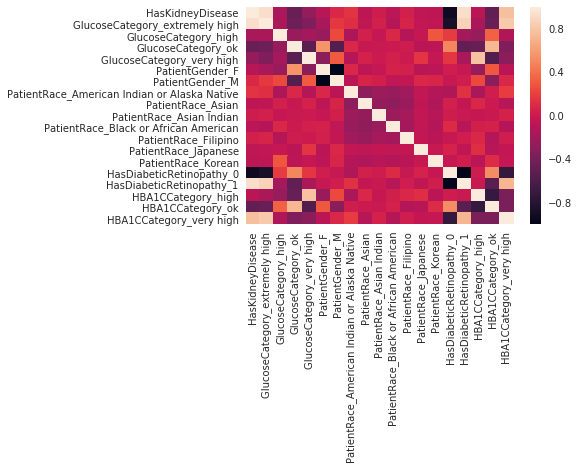

In [21]:
#HeatMap for OneHotEncoding
sns.heatmap(dfDiabetesStudySelectedOneHot.corr())
plt.show()

# Creating Test and Train split
# Split arrays or matrices into random train and test subsets

# Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.

In [22]:
##X - > Samples and Features
##Y - > Samples
HasReadmissionX = dfDiabetesStudySelectedOneHot.iloc[:,1:]
HasReadmissionY = dfDiabetesStudySelectedOneHot.iloc[:,0]
HasReadmissionX_train, HasReadmissionX_test, HasReadmissionY_train, HasReadmissionY_test = train_test_split(HasReadmissionX, HasReadmissionY, test_size=0.9)

print ("train_x size :: ", HasReadmissionX_train.shape)
print ("train_y size :: ", HasReadmissionY_train.shape)
 
print ("test_x size :: ", HasReadmissionX_test.shape)
print ("test_y size :: ", HasReadmissionY_test.shape)

train_x size ::  (20, 18)
train_y size ::  (20,)
test_x size ::  (180, 18)
test_y size ::  (180,)


# Logistics Regression function on TRAIN SET and TEST SET

In [23]:
classifier = LogisticRegression()
classifier.fit(HasReadmissionX_train,HasReadmissionY_train)
# check the accuracy on the training set
classifier.score(HasReadmissionX_train, HasReadmissionY_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

1.0

In [24]:
classifier = LogisticRegression()
classifier.fit(HasReadmissionX_test,HasReadmissionY_test)
# check the accuracy on the training set
classifier.score(HasReadmissionX_test, HasReadmissionY_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.99444444444444446

In [25]:
HasReadmissionY_train.mean()

0.29999999999999999

# Coefficients . What are the most influential predictors?

In [26]:
pd.DataFrame(list(zip(HasReadmissionX_train.columns, np.transpose(classifier.coef_))))

,0,1
0,GlucoseCategory_extremely high,[1.59992628402]
1,GlucoseCategory_high,[-0.254365478395]
2,GlucoseCategory_ok,[-0.861726956407]
3,GlucoseCategory_very high,[-0.878835974012]
4,PatientGender_F,[-0.193563806526]
5,PatientGender_M,[-0.201438318265]
6,PatientRace_American Indian or Alaska Native,[0.468923160338]
7,PatientRace_Asian,[-0.293178513589]
8,PatientRace_Asian Indian,[0.00301936648871]
9,PatientRace_Black or African American,[0.131700005213]


# PREDICTION RESULTS

In [27]:
# predict class labels for the test set
predicted = classifier.predict(HasReadmissionX_test)
print(predicted)

[0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1]


In [28]:
# generate class probabilities
probs = classifier.predict_proba(HasReadmissionX_test)
print(probs)

[[ 0.96736456  0.03263544]
 [ 0.05476867  0.94523133]
 [ 0.97648681  0.02351319]
 [ 0.02462252  0.97537748]
 [ 0.0715552   0.9284448 ]
 [ 0.02751221  0.97248779]
 [ 0.65130086  0.34869914]
 [ 0.09584883  0.90415117]
 [ 0.99044641  0.00955359]
 [ 0.98105227  0.01894773]
 [ 0.97880279  0.02119721]
 [ 0.55642448  0.44357552]
 [ 0.99217539  0.00782461]
 [ 0.99044641  0.00955359]
 [ 0.98449976  0.01550024]
 [ 0.01783648  0.98216352]
 [ 0.97926705  0.02073295]
 [ 0.99223629  0.00776371]
 [ 0.97926705  0.02073295]
 [ 0.98584093  0.01415907]
 [ 0.98808238  0.01191762]
 [ 0.98449976  0.01550024]
 [ 0.01769906  0.98230094]
 [ 0.98808238  0.01191762]
 [ 0.98351042  0.01648958]
 [ 0.98338222  0.01661778]
 [ 0.97880279  0.02119721]
 [ 0.97926705  0.02073295]
 [ 0.98808238  0.01191762]
 [ 0.98449976  0.01550024]
 [ 0.45060783  0.54939217]
 [ 0.99223629  0.00776371]
 [ 0.99217539  0.00782461]
 [ 0.98958773  0.01041227]
 [ 0.98338222  0.01661778]
 [ 0.98958773  0.01041227]
 [ 0.98950627  0.01049373]
 

# Compute confusion matrix to evaluate the accuracy of a classification
#By definition a confusion matrix C is such that C_{i, j} is equal to the number of observations known to be in group i but predicted to be in group j.
#Thus in binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.


In [29]:
HasReadmissionY_pred=classifier.predict(HasReadmissionX_test)

from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(HasReadmissionY_test,HasReadmissionY_pred)
print(confusion_matrix)

[[136   0]
 [  1  43]]


In [30]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(HasReadmissionX_test, HasReadmissionY_test)))


Accuracy of logistic regression classifier on test set: 0.99
